In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [2]:
out = util.load("outfiles/Run3Summer22/PV/cutflow_TTtoLNu2Q_short_old.coffea")

In [17]:
import pandas as pd

lumis = {
    "2022d" : 100
}
xs = {
    "TTtoLNu2Q" : 762.1,
    "QCD" : 222.1,
}
era = "2022d"

scale_lumi = {k: xs[k] * lumis[era] / w for k, w in out['sumw'].items()}

df = pd.DataFrame([])
h = out["cutflow"][{
    "pn_Hbb" : slice(hist.underflow, hist.overflow, sum), 
    "pt" : slice(hist.underflow, hist.overflow, sum),
    "msoftdrop" : slice(hist.underflow, hist.overflow, sum),
}]

for i, name in enumerate(h.axes["dataset"]):
    h.view(flow=True)[i] *= scale_lumi[name]

df["Total"] = h[{"dataset" : sum, "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}].values()
#df["Uncertanity"] = np.sqrt(h[{"dataset" : sum, "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}].variances())

df["Non"] = h[{"dataset" : sum, "cat" : hist.loc(3)}].values()
df["W"] = h[{"dataset" : sum, "cat" : hist.loc(2)}].values()
df["Top"] = h[{"dataset" : sum, "cat" : hist.loc(1)}].values()

df.index = ['Nothing','HLT_Mu50','AK8 p$_T$ > 200 GeV','MET $>$ 50 GeV','Good muon','Leptonic W p$_T$ > 150','Same hem. AK4 b-jet','Opp. hem. AK8 jet', 'Muon isolation']

df.style.format("{:,.1f}")

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


,Total,Non,W,Top
Nothing,"1,605.1","1,498.0",79.7,27.4
HLT_Mu50,"1,554.4","1,450.5",77.3,26.6
AK8 p$_T$ > 200 GeV,268.5,197.5,45.4,25.6
MET $>$ 50 GeV,188.2,136.3,31.8,20.1
Good muon,188.2,136.3,31.8,20.1
Leptonic W p$_T$ > 150,129.7,89.4,24.1,16.3
Same hem. AK4 b-jet,120.8,83.4,22.2,15.2
Opp. hem. AK8 jet,120.8,83.4,22.2,15.2
Muon isolation,8.6,6.0,1.3,1.2


In [18]:
for column in ["Total", "Non", "W", "Top"]:

    percentage = []

    for i in range(len(df[column])):
        percentage.append(df[column][i] / df[column][1] * 100)
        
    df[f"{column} %"] = percentage

df.style.format("{:,.1f}")

,Total,Non,W,Top,Total %,Non %,W %,Top %
Nothing,"1,605.1","1,498.0",79.7,27.4,103.3,103.3,103.0,102.7
HLT_Mu50,"1,554.4","1,450.5",77.3,26.6,100.0,100.0,100.0,100.0
AK8 p$_T$ > 200 GeV,268.5,197.5,45.4,25.6,17.3,13.6,58.8,96.0
MET $>$ 50 GeV,188.2,136.3,31.8,20.1,12.1,9.4,41.2,75.5
Good muon,188.2,136.3,31.8,20.1,12.1,9.4,41.2,75.5
Leptonic W p$_T$ > 150,129.7,89.4,24.1,16.3,8.3,6.2,31.1,61.1
Same hem. AK4 b-jet,120.8,83.4,22.2,15.2,7.8,5.7,28.8,56.9
Opp. hem. AK8 jet,120.8,83.4,22.2,15.2,7.8,5.7,28.8,56.9
Muon isolation,8.6,6.0,1.3,1.2,0.6,0.4,1.7,4.7


In [19]:
for column in ["Total", "Non", "W", "Top"]:

    rel_percentage = []

    for i in range(len(df[column])):
        rel_percentage.append(df[column][i] / df[column][i-1 if i > 1 else 1] * 100)

    df[f"{column} (rel %)"] = rel_percentage

df.style.format("{:,.1f}")

,Total,Non,W,Top,Total %,Non %,W %,Top %,Total (rel %),Non (rel %),W (rel %),Top (rel %)
Nothing,"1,605.1","1,498.0",79.7,27.4,103.3,103.3,103.0,102.7,103.3,103.3,103.0,102.7
HLT_Mu50,"1,554.4","1,450.5",77.3,26.6,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
AK8 p$_T$ > 200 GeV,268.5,197.5,45.4,25.6,17.3,13.6,58.8,96.0,17.3,13.6,58.8,96.0
MET $>$ 50 GeV,188.2,136.3,31.8,20.1,12.1,9.4,41.2,75.5,70.1,69.0,70.1,78.6
Good muon,188.2,136.3,31.8,20.1,12.1,9.4,41.2,75.5,100.0,100.0,100.0,100.0
Leptonic W p$_T$ > 150,129.7,89.4,24.1,16.3,8.3,6.2,31.1,61.1,68.9,65.6,75.6,81.0
Same hem. AK4 b-jet,120.8,83.4,22.2,15.2,7.8,5.7,28.8,56.9,93.1,93.3,92.4,93.2
Opp. hem. AK8 jet,120.8,83.4,22.2,15.2,7.8,5.7,28.8,56.9,100.0,100.0,100.0,100.0
Muon isolation,8.6,6.0,1.3,1.2,0.6,0.4,1.7,4.7,7.1,7.2,5.8,8.2


/opt/conda/lib/python3.8/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


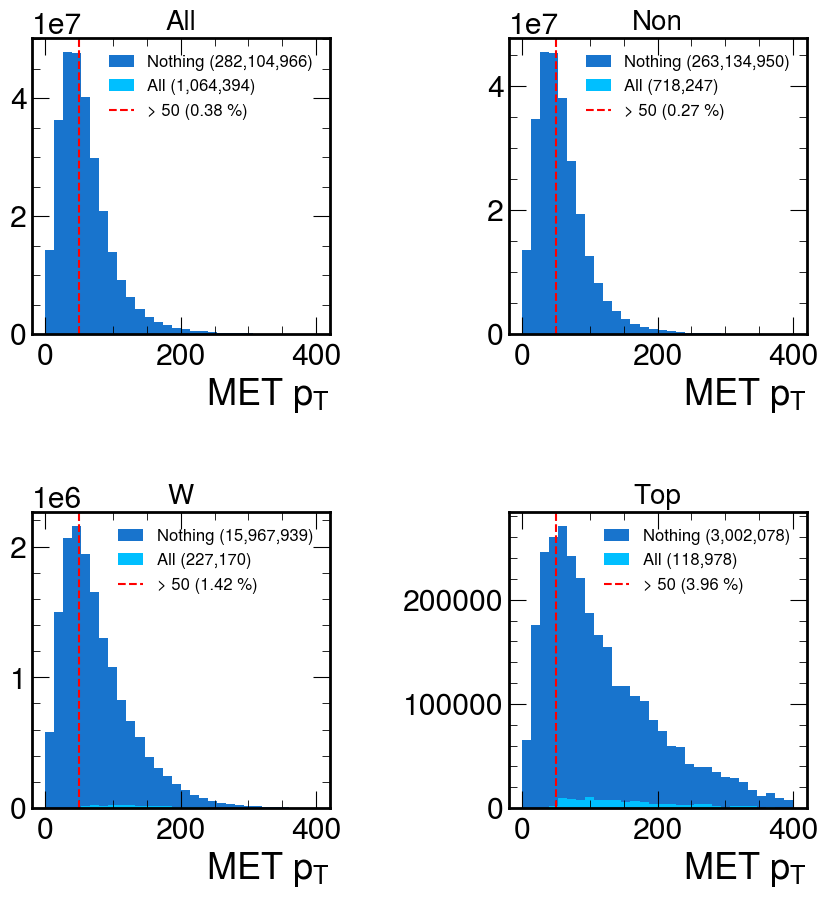

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "met"
var = "pt"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(50, color='red',ls='--', label=f"> 50 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    
    column += 1

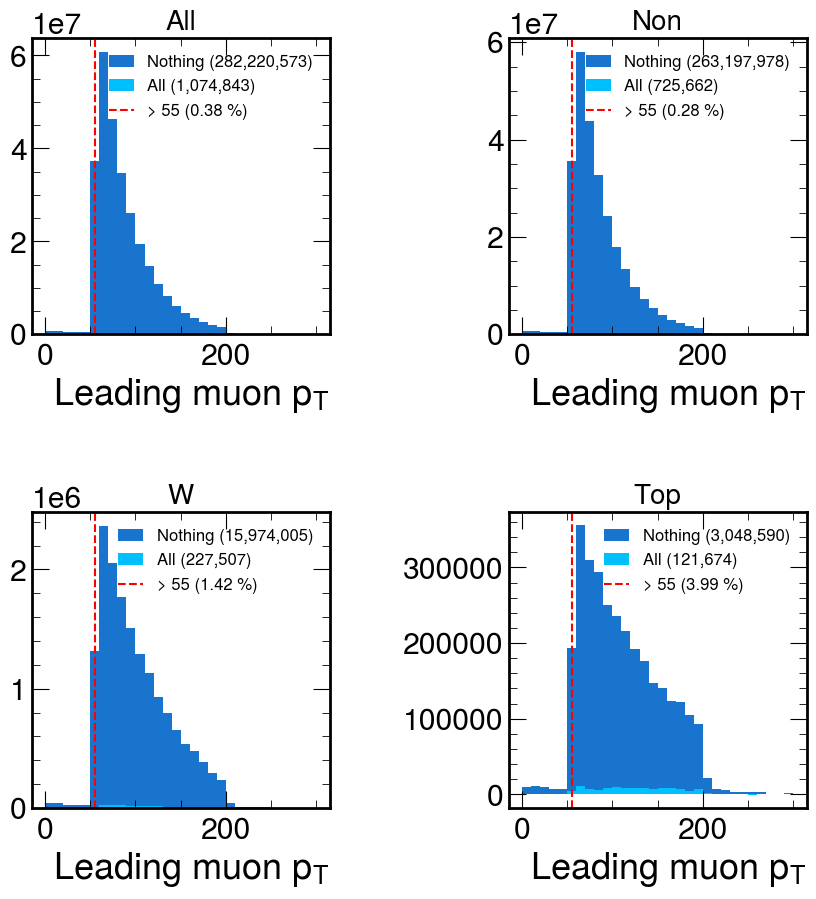

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "goodmuon"
var = "pt"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(55, color='red',ls='--', label=f"> 55 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    
    column += 1

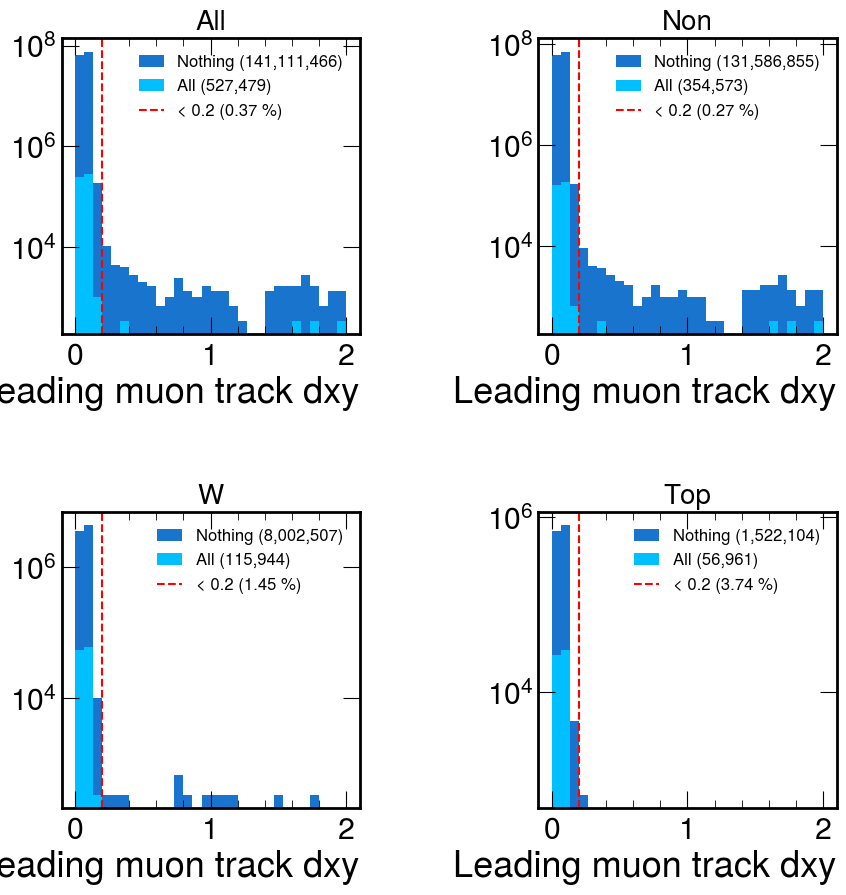

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "goodmuon"
var = "trk_dxy"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(0.2, color='red',ls='--', label=f"< 0.2 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    ax[row, column].set_yscale("log")
    
    column += 1

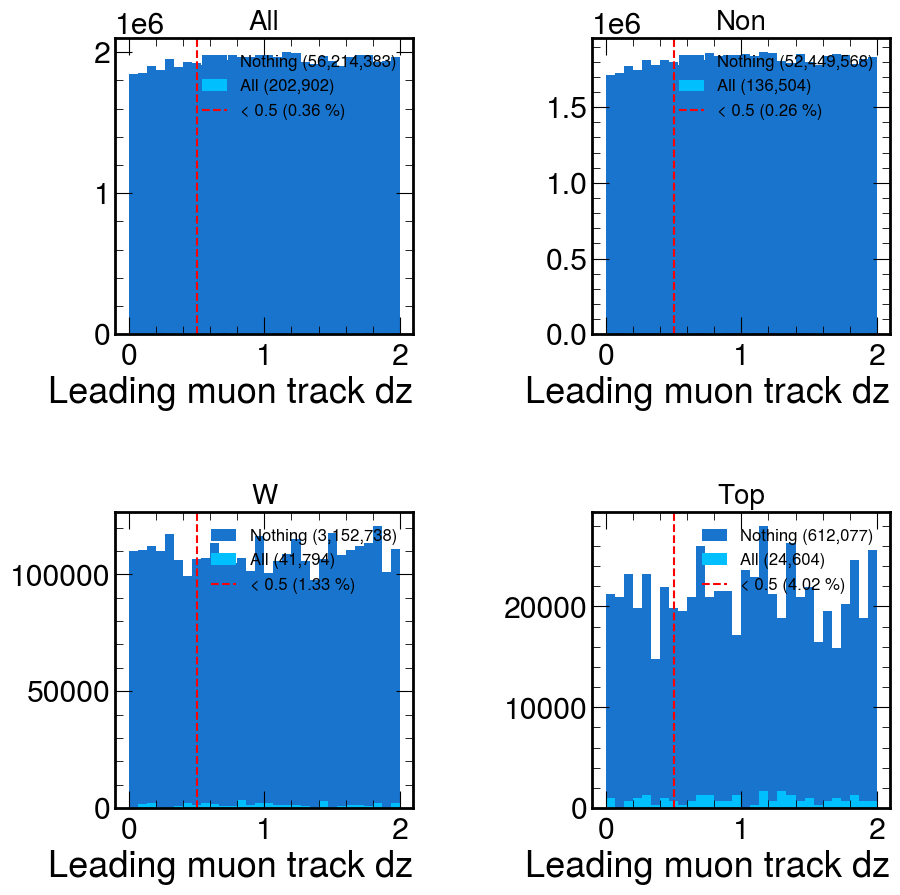

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "goodmuon"
var = "trk_dz"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(0.5, color='red',ls='--', label=f"< 0.5 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    
    column += 1

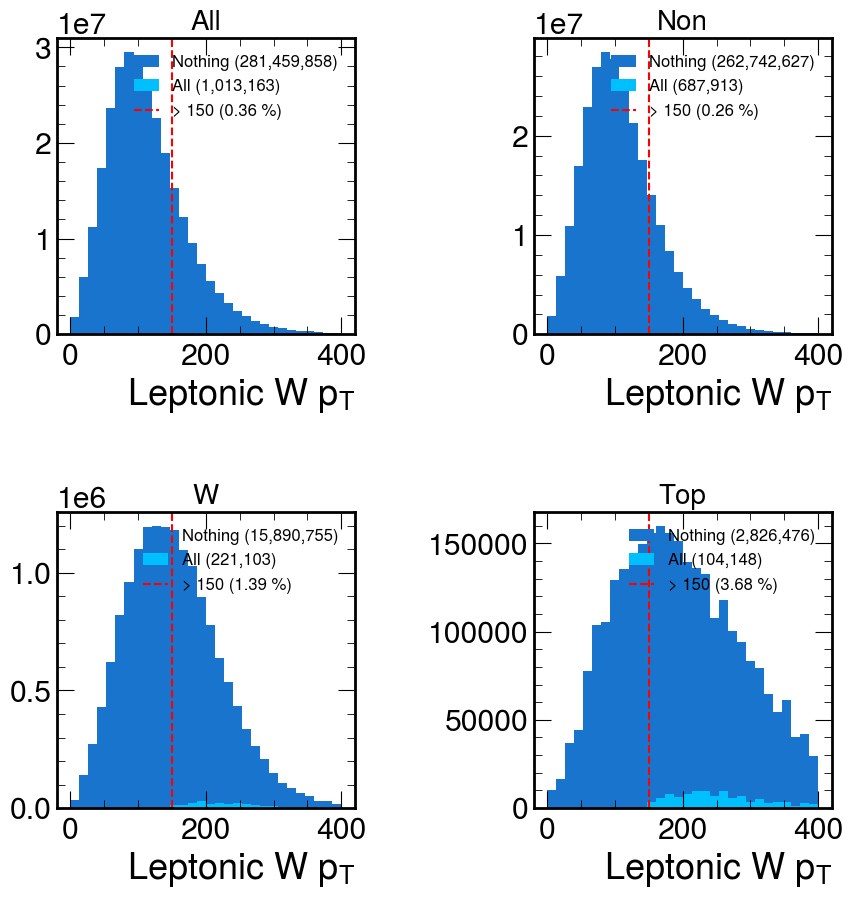

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "leptonicW"
var = "pt"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(150, color='red',ls='--', label=f"> 150 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    
    column += 1

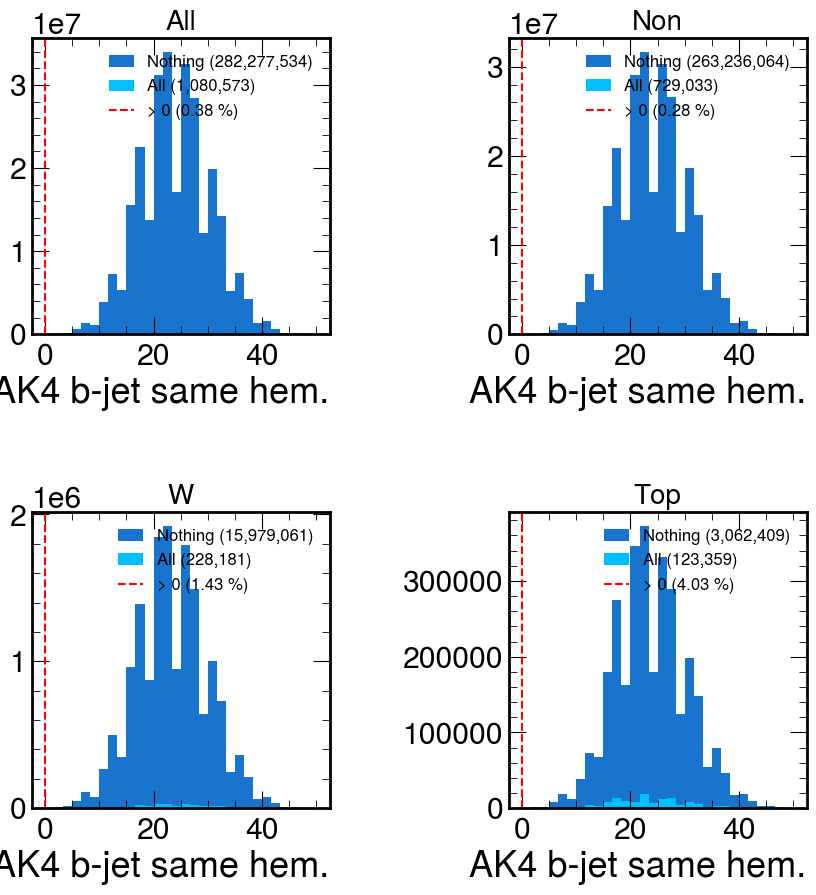

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "ak4bjet"
var = "njets"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(0, color='red',ls='--', label=f"> 0 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    ax[row, column].set_xlabel("AK4 b-jet same hem.")
    
    column += 1

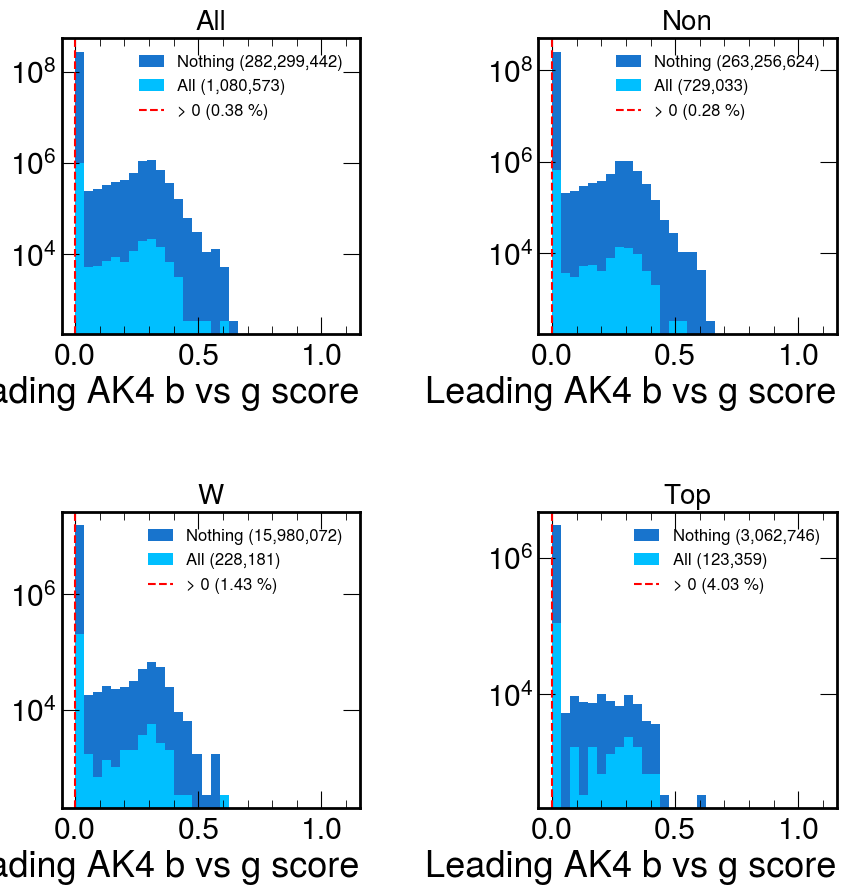

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "ak4bjet"
var = "pn_b_1"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(0, color='red',ls='--', label=f"> 0 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    ax[row, column].set_yscale("log")
    
    column += 1

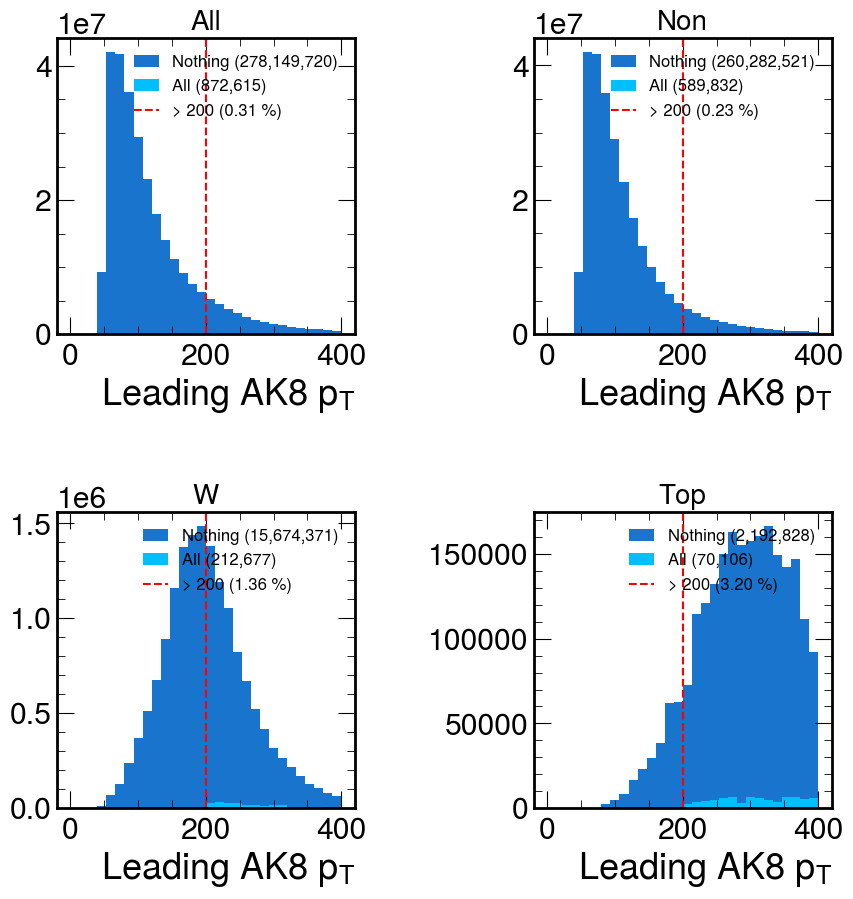

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "ak8jet"
var = "pt"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(200, color='red',ls='--', label=f"> 200 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    
    column += 1

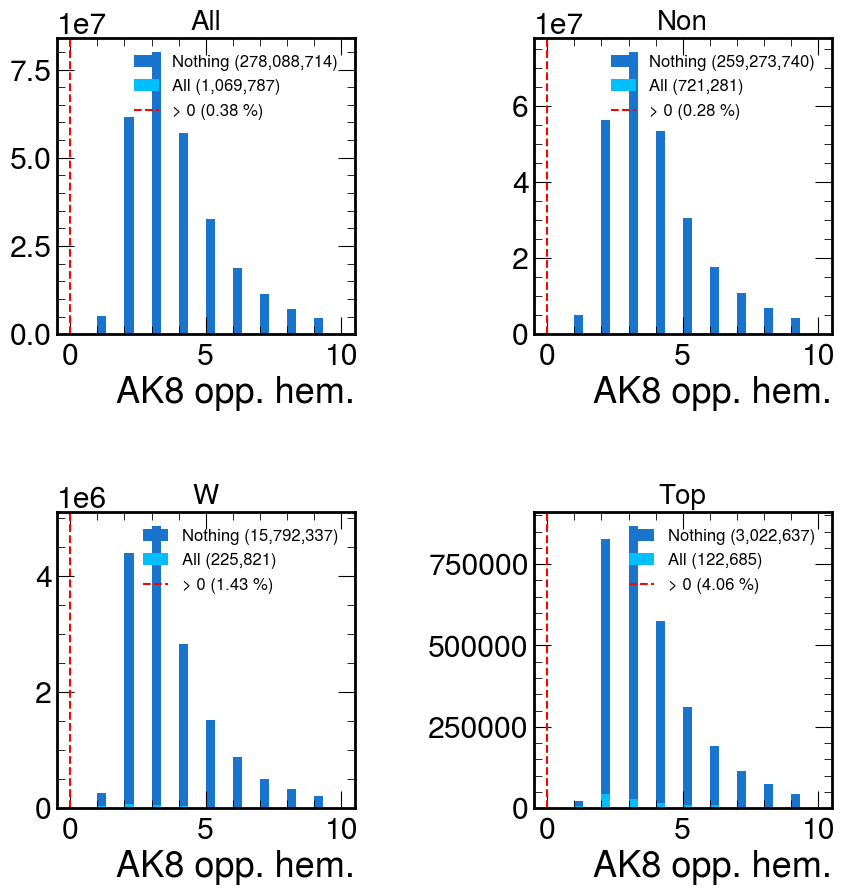

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "ak8jet"
var = "njets"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(0, color='red',ls='--', label=f"> 0 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    ax[row, column].set_xlabel("AK8 opp. hem.")
    
    column += 1

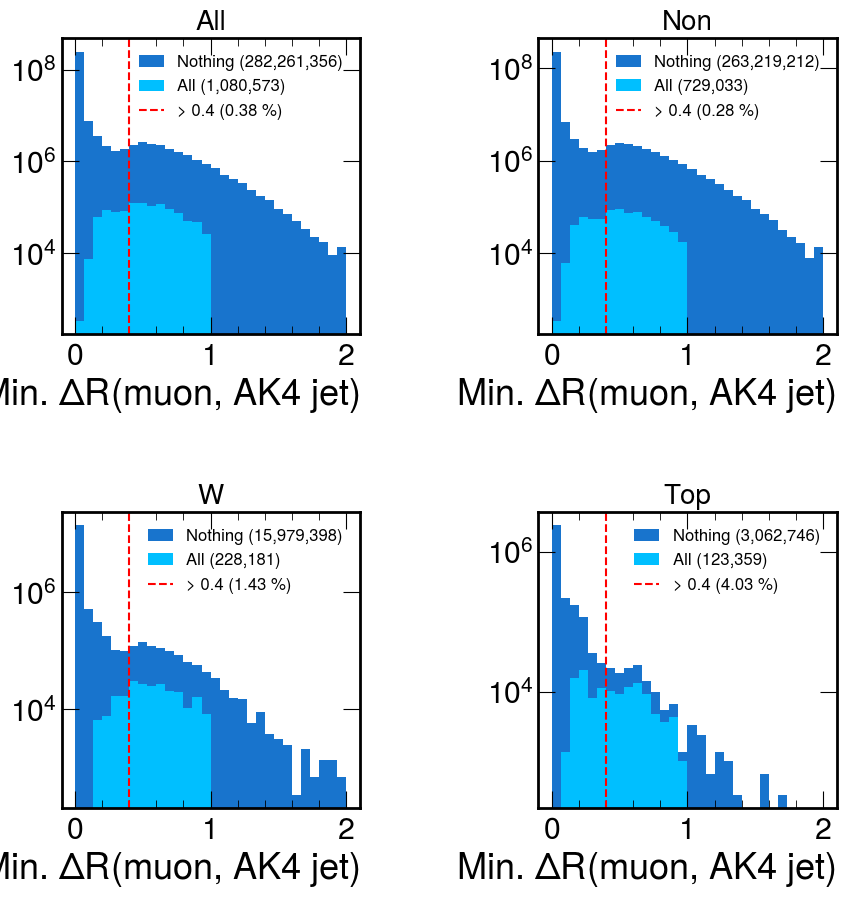

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "mujetiso"
var = "dr"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(0.4, color='red',ls='--', label=f"> 0.4 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    ax[row, column].set_yscale("log")
    
    column += 1

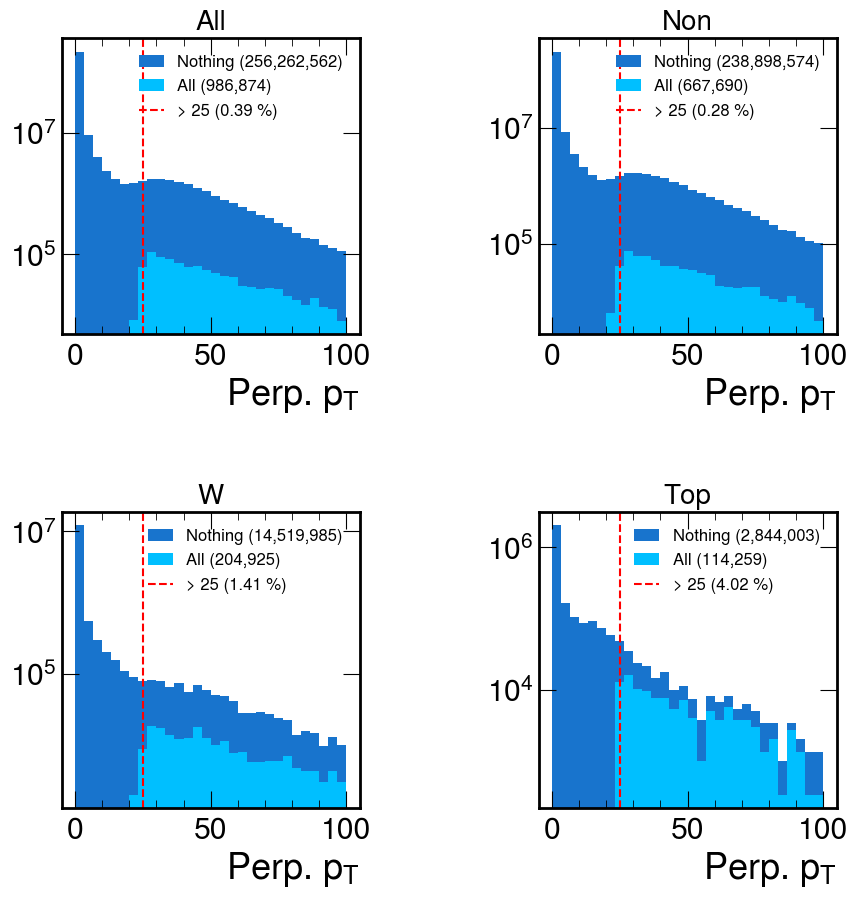

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "mujetiso"
var = "pt"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var, "cat")[hist.loc("noselection"), :, hist.loc(cat)]
        h_all = out[thing].project("region", var, "cat")[hist.loc("all"), :, hist.loc(cat)]
    
    n_no = h_no[slice(hist.underflow+1, hist.overflow-1,sum)].value
    n_all = h_all[slice(hist.underflow+1, hist.overflow-1,sum)].value
            
    mplhep.histplot(h_no, ax=ax[row, column], color=colours["no"], label=f"Nothing ({n_no:,.0f})", yerr=False, histtype='fill', alpha=1,)
    mplhep.histplot(h_all, ax=ax[row, column], color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(25, color='red',ls='--', label=f"> 25 ({n_all/n_no * 100:,.2f} %)")

    ax[row, column].legend(loc='best', fontsize=12)
    ax[row, column].set_title(titles[cat], fontsize=20)
    ax[row, column].set_xlabel(r"Perp. p$_T$")
    ax[row, column].set_yscale("log")
    
    column += 1

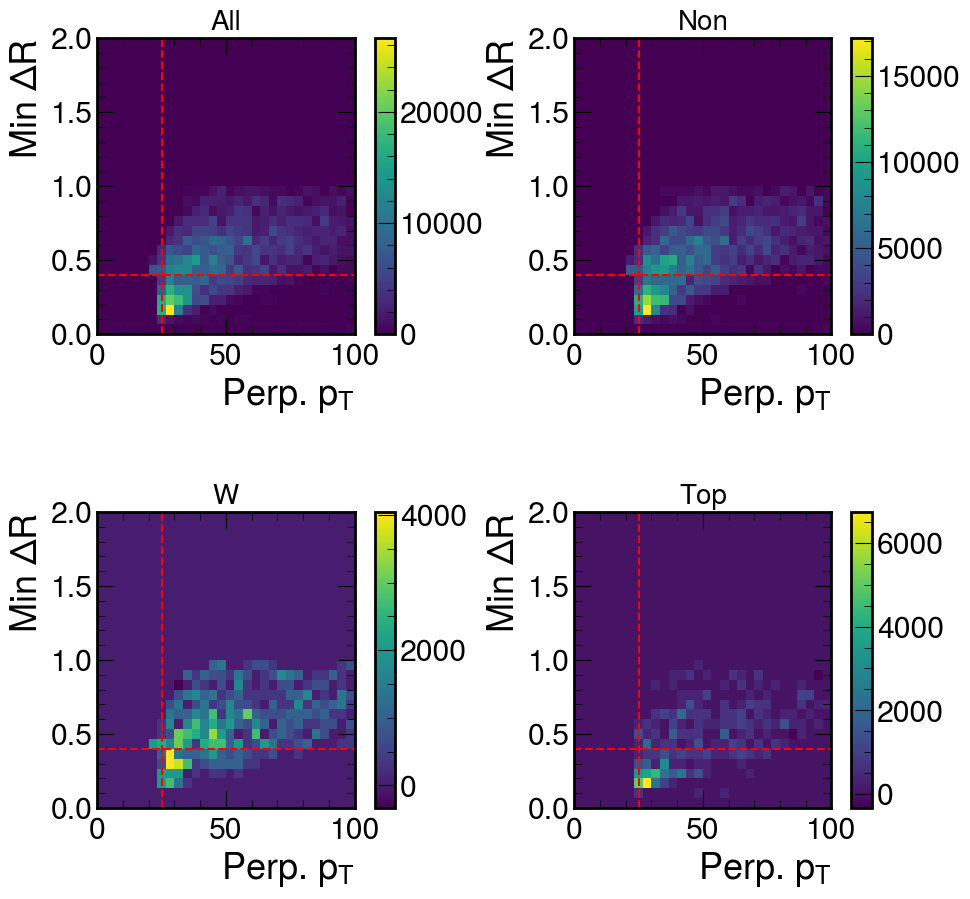

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

labels = {
    "no" : "Nothing",
    "all" : "All",
}

colours = {
    "no" : "#1874CD", 
    "all" : "#00BFFF",
}

titles = {
    0 : "All",
    3 : "Non",
    2 : "W",
    1 : "Top",
}

thing = "mujetiso"
var2 = "dr"
var1 = "pt"

row, column = 0, 0

for i, cat in enumerate([0, 3, 2, 1]):
    
    if i == 2:
        row = 1
        column = 0
    
    if i == 0:
        h_no = out[thing].project("region", var1, var2, "cat")[{"region" : hist.loc("noselection"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
        h_all = out[thing].project("region", var1, var2, "cat")[{"region" : hist.loc("all"), "cat" : [hist.loc(3), hist.loc(2), hist.loc(1)]}][{"cat" : sum}]
    else:
        h_no = out[thing].project("region", var1, var2, "cat")[hist.loc("noselection"), :, :, hist.loc(cat)]
        h_all = out[thing].project("region", var1, var2, "cat")[hist.loc("all"), :, :, hist.loc(cat)]
            
    mplhep.hist2dplot(h_all, ax=ax[row, column]) #, color=colours["all"], label=f"All ({n_all:,.0f})", yerr=False, histtype='fill', alpha=1,)
    ax[row, column].axvline(25, color='red',ls='--')
    ax[row, column].axhline(0.4, color='red',ls='--')

    ax[row, column].set_title(titles[cat], fontsize=20)
    ax[row, column].set_ylabel(r"Min $\Delta$R")
    ax[row, column].set_xlabel(r"Perp. p$_T$")

    column += 1